# Objetivo

In [1]:
import os.path as pth
import time

import pandas as pd
import numpy as np

import requests
import json

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.patches as mpatches
import matplotlib.units as munits

import matplotlib.colors as colors

from datetime import datetime,timedelta,date
import seaborn as sns
%matplotlib inline

import html
import twitter
import sys
import locale



# variables globales

In [2]:
path_proyecto = '/Users/mharias/documents/proyectos/mercamadrid/'

In [3]:
path_ficheros = ['https://datos.madrid.es/egob/catalogo/300357-6-mercamadrid-volumen-precio.csv',
                 'https://datos.madrid.es/egob/catalogo/300357-4-mercamadrid-volumen-precio.csv',
                 'https://datos.madrid.es/egob/catalogo/300357-2-mercamadrid-volumen-precio.csv',
                 'https://datos.madrid.es/egob/catalogo/300357-0-mercamadrid-volumen-precio.csv']

# Importamos los datos

In [4]:
storage_options = {'User-Agent': 'Mozilla/5.0'}

In [5]:
lista_datos=[]
for fichero in path_ficheros:
    lista_datos.append(pd.read_csv(fichero, storage_options=storage_options,encoding='latin-1',sep=';'))


In [6]:
df = pd.concat(lista_datos).query("`Fecha Desde`!='Fecha Desde'")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176958 entries, 0 to 50252
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Fecha Desde            176958 non-null  object
 1    Fecha Hasta           176958 non-null  object
 2    Código Variedad       176958 non-null  object
 3    Descripción Variedad  176958 non-null  object
 4    Origen                176958 non-null  object
 5    Descripción Origen    176958 non-null  object
 6    Kilos                 176958 non-null  object
 7    Precio Más Frecuente  176958 non-null  object
 8    Precio Máximo         176958 non-null  object
 9    Precio Mínimo         176958 non-null  object
dtypes: object(10)
memory usage: 14.9+ MB


In [8]:
df.columns

Index(['Fecha Desde', ' Fecha Hasta', ' Código Variedad',
       ' Descripción Variedad', ' Origen', ' Descripción Origen', ' Kilos',
       ' Precio Más Frecuente', ' Precio Máximo', ' Precio Mínimo'],
      dtype='object')

In [9]:
datos = (df.
 assign(fecha=pd.to_datetime(df['Fecha Desde'],format='%Y%m%d')).
 assign(codigo_variedad=lambda df_:df_[' Código Variedad'].str.strip()).
 assign(descripcion_variedad=lambda df_:df_[' Descripción Variedad'].str.strip()).
 assign(origen = lambda df_:df_[' Origen'].str.strip()).
 assign(descripcion_origen = lambda df_:df_[' Descripción Origen'].str.strip()).
 assign(kilos = lambda df_:df_[' Kilos'].astype('float')).
 assign(precio_max = df[' Precio Máximo'].apply(lambda row: float(row.replace(',','.')))).
 assign(precio_min = df[' Precio Mínimo'].apply(lambda row: float(row.replace(',','.')))).
 assign(precio_freq = df[' Precio Más Frecuente'].apply(lambda row: float(row.replace(',','.')))).
 drop(['Fecha Desde', ' Fecha Hasta', ' Código Variedad',
       ' Descripción Variedad', ' Origen', ' Descripción Origen', ' Kilos',
       ' Precio Más Frecuente', ' Precio Máximo', ' Precio Mínimo',],axis=1)
)

In [10]:
datos = datos.loc[~datos[['fecha','codigo_variedad','kilos']].duplicated(),:]

In [11]:
datos.dtypes

fecha                   datetime64[ns]
codigo_variedad                 object
descripcion_variedad            object
origen                          object
descripcion_origen              object
kilos                          float64
precio_max                     float64
precio_min                     float64
precio_freq                    float64
dtype: object

In [12]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817 entries, 0 to 50252
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   fecha                 167817 non-null  datetime64[ns]
 1   codigo_variedad       167817 non-null  object        
 2   descripcion_variedad  167817 non-null  object        
 3   origen                167817 non-null  object        
 4   descripcion_origen    167817 non-null  object        
 5   kilos                 167817 non-null  float64       
 6   precio_max            167817 non-null  float64       
 7   precio_min            167817 non-null  float64       
 8   precio_freq           167817 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 12.8+ MB


In [13]:
productos = ['VACUNO DESPIECE AÑOJO',
             'PORCINO DESPIECE',
             'HUEVOS',
             'POLLO',
             'FRESON',
             'MANZANA ROYAL GALA',
             'PLATANO IMPORT. O BANANA',
             'ACELGAS',
             'CEBOLLA GRANO DE ORO',
             'JUDIA VERDE HELDA',
             'PIMIENTO VERDE ITALIANO',
             'BOQUERON NCNAL.TERCIADO',
             'PATATA BLANCA',
             'LUBINA ACUICULTU. MEDIANA',
             'PERCEBE NACIONAL'
             ]

In [14]:
fechas_x = [pd.to_datetime(i).strftime('%b-%y') for i in datos.sort_values('fecha')['fecha'].unique()]

In [15]:
fechas_x[::3]

['Jan-19',
 'Apr-19',
 'Jul-19',
 'Oct-19',
 'Jan-20',
 'Apr-20',
 'Jul-20',
 'Oct-20',
 'Jan-21',
 'Apr-21',
 'Jul-21',
 'Oct-21',
 'Jan-22',
 'Apr-22',
 'Jul-22']

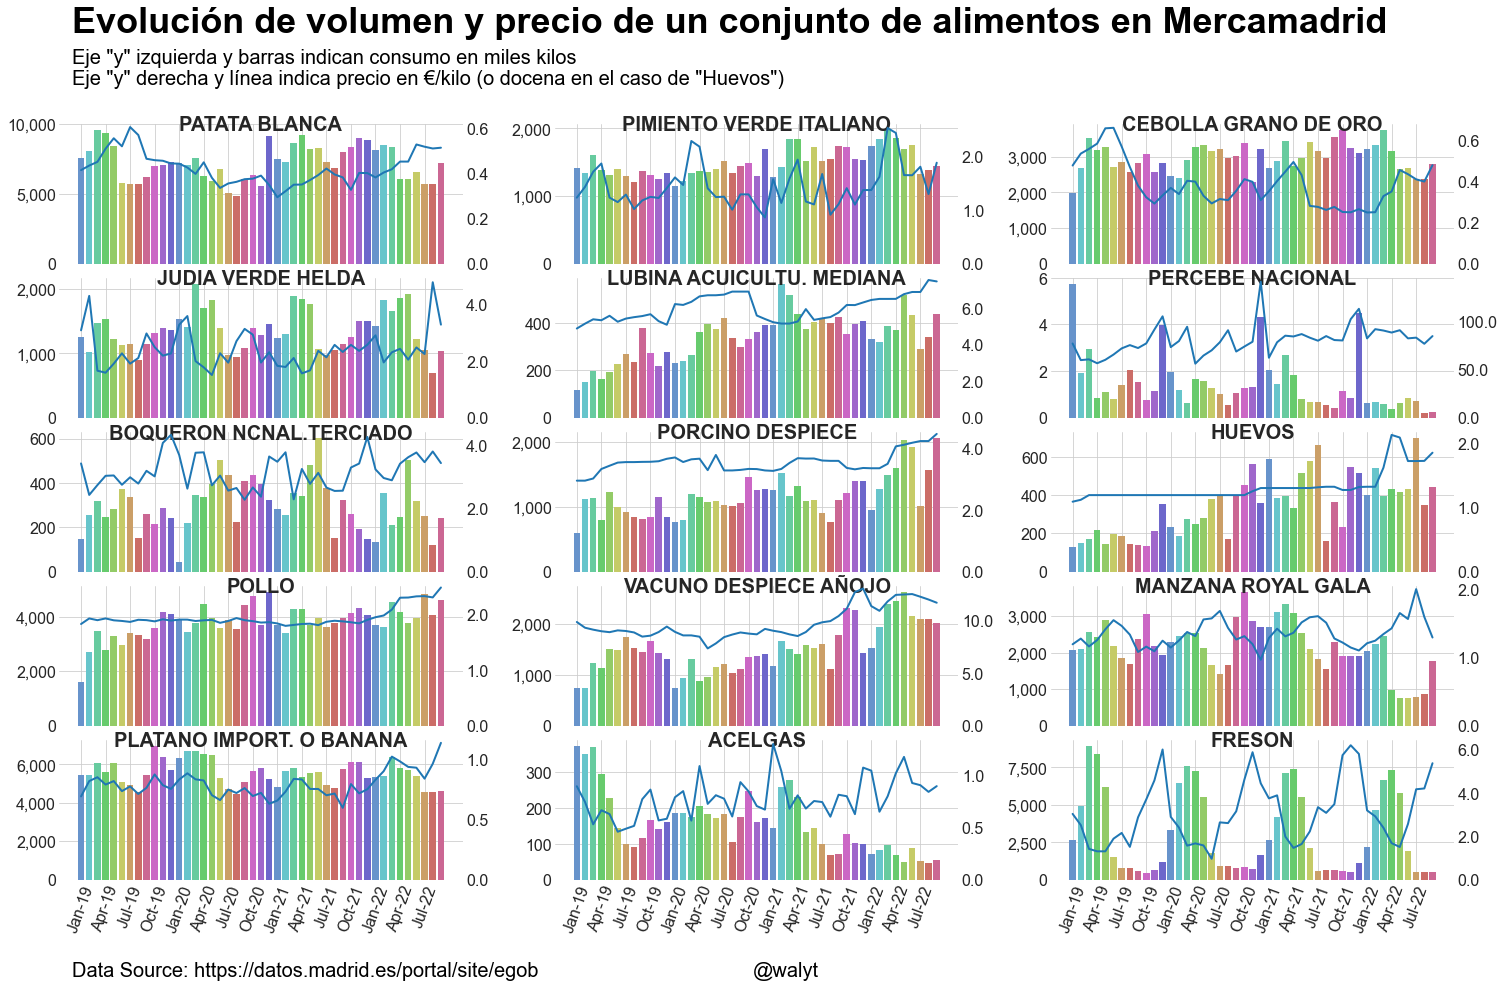

In [16]:
locale.setlocale(locale.LC_ALL,'')
sns.set_style(style='white')
g = sns.catplot(
    data=datos.loc[datos['descripcion_variedad'].isin(productos),:].sort_values('fecha',ascending=True),
    x="fecha", y="kilos", col="descripcion_variedad",
      linewidth=0,palette=np.roll(sns.color_palette("hls",12)[::-1],shift=8,axis=0),kind='bar',zorder=1,
    col_wrap=3, height=2.8, aspect=2.5, legend=False,sharey=False,ci=None,estimator=sum
)



fuente = 'https://datos.madrid.es/portal/site/egob'
titulo = f"Evolución de volumen y precio de un conjunto de alimentos en Mercamadrid"
autor='@walyt'

for producto, ax in g.axes_dict.items():

    
    ax.text(.5, .95, producto, transform=ax.transAxes, fontweight="bold",fontsize=20,ha='center')

   
    ax.xaxis.set_tick_params(labelsize=16,width=0,rotation=70,pad=0)
    ax.yaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f}'))
    sns.despine(left=True, bottom=True)
    ax.grid(True)
    ax.set_xticks(range(0,44,3))
    ax.set_xticklabels(fechas_x[::3])
    ax1=ax.twinx()
    ax1.plot(range(0,45,1),
             datos.
             loc[datos['descripcion_variedad']==producto,:].
             sort_values('fecha',ascending=True).
             groupby(['fecha']).
             mean().
             reset_index()['precio_freq'],
            lw=2)
    ax1.yaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v:,.1f}'))
    ax1.set_ylim(bottom=0)
    sns.despine(left=True, bottom=True)
    
g.set_titles("")
g.set_axis_labels("", "",fontsize=20)
g.tight_layout()
g.fig.subplots_adjust(top=.85,bottom=.1,wspace=.23,hspace=.1)

g.fig.text(0.05, 0.95, '{}'.format(titulo),fontsize=36,color='black',
             verticalalignment='center',fontweight='bold')
g.fig.text(0.05, 0.915, 'Eje "y" izquierda y barras indican consumo en miles kilos',
             verticalalignment='center', fontsize=20,color='black')
g.fig.text(0.05, 0.895, 'Eje "y" derecha y línea indica precio en €/kilo (o docena en el caso de "Huevos")',
             verticalalignment='center', fontsize=20,color='black')
g.fig.text(0.05, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
g.fig.text(0.5,0.01,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')
path_imagen = '{}img/evolucion_consumo_precio.png'.format(path_proyecto)
g.savefig(path_imagen,dpi=288,bbox_inches='tight')